In [1]:
import torch
import pandas
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset
from tqdm import tqdm
import matplotlib.pyplot as plt
import torch.nn as nn
import numpy as np
import pandas as pd

In [2]:
# if using colab, uncomment the following lines
from google.colab import drive
drive.mount('/content/drive')
%cd '/content/drive/My Drive/TorqueAllocator/'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/My Drive/TorqueAllocator


In [3]:
# Load the data
filename = 'results/TA_optimization.csv'
data = pandas.read_csv(filename, index_col=0)
data.head()

input_names = data.columns[:6]
output_names = data.columns[6:10]
print("Input names: ", input_names)
print("Output names: ", output_names)

Input names:  Index(['Tcmd', 'dT_ref', 'FL_max', 'FR_max', 'RL_max', 'RR_max'], dtype='object')
Output names:  Index(['FL', 'FR', 'RL', 'RR'], dtype='object')


In [4]:
X = data[input_names].values
y = data[output_names].values

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create the data loaders
train_data = TensorDataset(torch.Tensor(X_train), torch.Tensor(y_train))
eval_data = TensorDataset(torch.Tensor(X_test), torch.Tensor(y_test))

# # Standardize the data
# scaler_x = StandardScaler()
# X_train = scaler_x.fit_transform(X_train)
# X_test = scaler_x.transform(X_test)
#
# # Standardize the output
# scaler_y = StandardScaler()
# y_train = scaler_y.fit_transform(y_train)
# y_test = scaler_y.transform(y_test)

# Create the data loaders
batch_size = 256
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
eval_loader = DataLoader(eval_data, batch_size=batch_size, shuffle=False)

data_loaders = {'train': train_loader,'eval': eval_loader}
data_sizes = {'train': len(train_data), 'eval': len(eval_data)}

In [5]:
class SimpleNet(torch.nn.Module):
    def __init__(self, input_size, output_size):
        super(SimpleNet, self).__init__()
        h_size = 32
        self.fc1 = nn.Linear(input_size, h_size)
        # self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(h_size, h_size)
        self.fc4 = nn.Linear(h_size, h_size)
        self.fc5 = nn.Linear(h_size, output_size)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.fc1(x))
        # x = self.relu(self.fc2(x))
        x = self.relu(self.fc3(x))
        x = self.relu(self.fc4(x))
        x = self.fc5(x)
        return x

In [6]:
def train(model, data_loaders, data_sizes, criterion, optimizer, scheduler, device, num_epochs):

    losses = {'train': [], 'eval': []}
    best_model_wts = model.state_dict()
    best_loss = 1e10

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        for phase in ['train', 'eval']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0

            for inputs, labels in data_loaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)

            if phase == 'train':
                scheduler.step()
            epoch_loss = running_loss / data_sizes[phase]
            losses[phase].append(epoch_loss)

            print('{} Loss: {:.4f}'.format(phase, epoch_loss))

            if phase == 'eval' and epoch_loss < best_loss:
                best_loss = epoch_loss
                best_model_wts = model.state_dict()

    torch.save(best_model_wts, 'models/TA_optimization_NN.pth')
    return model, losses

In [7]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Define the loss function
model = SimpleNet(len(input_names), len(output_names))
model.to(device)

# Define the optimizer
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=50, gamma=0.1)

In [8]:
# Train the model
model, losses = train(model, data_loaders, data_sizes, criterion, optimizer, scheduler, device, 200)

Epoch 0/199
----------
train Loss: 422.1003
eval Loss: 50.7734
Epoch 1/199
----------
train Loss: 42.9651
eval Loss: 55.8338
Epoch 2/199
----------
train Loss: 31.7408
eval Loss: 32.8061
Epoch 3/199
----------
train Loss: 26.7343
eval Loss: 19.2192
Epoch 4/199
----------
train Loss: 22.6576
eval Loss: 19.2889
Epoch 5/199
----------
train Loss: 20.9063
eval Loss: 22.8992
Epoch 6/199
----------
train Loss: 21.8110
eval Loss: 23.9767
Epoch 7/199
----------
train Loss: 19.0599
eval Loss: 18.3008
Epoch 8/199
----------
train Loss: 18.8983
eval Loss: 20.7977
Epoch 9/199
----------
train Loss: 19.0409
eval Loss: 22.4216
Epoch 10/199
----------
train Loss: 17.4842
eval Loss: 21.9949
Epoch 11/199
----------
train Loss: 18.3250
eval Loss: 18.5852
Epoch 12/199
----------
train Loss: 16.8001
eval Loss: 14.9709
Epoch 13/199
----------
train Loss: 17.4317
eval Loss: 16.0276
Epoch 14/199
----------
train Loss: 16.9098
eval Loss: 17.0108
Epoch 15/199
----------
train Loss: 16.6175
eval Loss: 23.8689
E

In [9]:
losses_df = pd.DataFrame([losses], columns=['mse'])
losses_file_name = 'results/TA_optim_losses.csv'
losses_df.to_csv(losses_file_name)

          train       eval
0    422.100253  50.773412
1     42.965052  55.833799
2     31.740813  32.806063
3     26.734289  19.219213
4     22.657629  19.288903
..          ...        ...
195    3.329556   3.532289
196    3.329735   3.531961
197    3.328972   3.534265
198    3.329716   3.533422
199    3.328810   3.533538

[200 rows x 2 columns]


<Axes: >

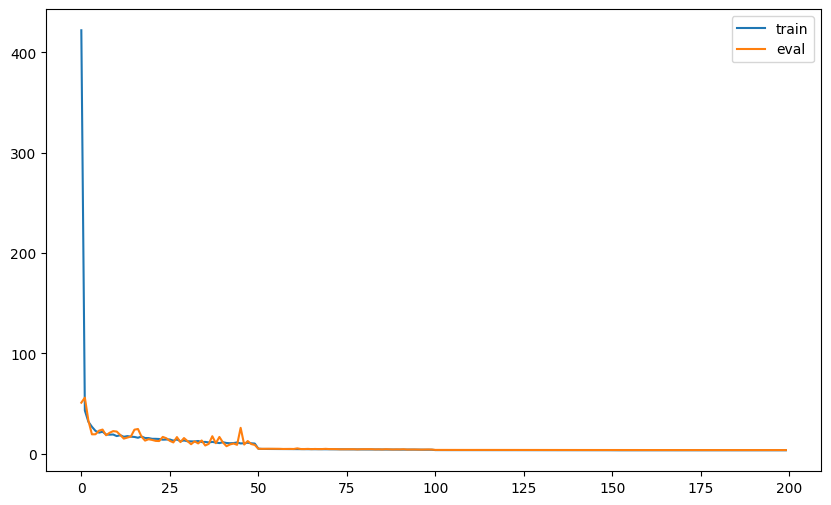

In [10]:
losses_df = pandas.DataFrame(losses)
print(losses_df)
fig, ax = plt.subplots(figsize=(10, 6))
losses_df.plot(ax=ax)

In [11]:
# Get baselines using sklearn models
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error


# Linear regression
lr = LinearRegression()
lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print(f'Linear regression MSE: {mse}')

Linear regression MSE: 1426.1676374950657


In [15]:
model.eval()

all_outputs = []
for inputs, labels in eval_loader:
  inputs = inputs.to(device)
  labels = labels.to(device)
  outputs = model(inputs).detach().cpu().numpy()
  all_outputs.append(outputs)

all_outputs = np.concatenate(all_outputs)

mse = mean_squared_error(y_test, all_outputs)
print(f'NN MSE: {mse}')


NN MSE: 3.5335383636586513


In [13]:
# Print linear regression evaluation
max_count = 5
for pred, true in zip(y_test[:max_count], all_outputs[:max_count]):
    print(pred, true)

[147.52876997 105.72961679 259.87994992  98.82250879] [147.392    104.24408  260.09424  100.387474]
[186.71083189  55.32142141  98.64349932  35.20156276] [185.44919   55.692146  99.43506   34.68746 ]
[-69.20793729  22.72479468  38.12909246   8.35364152] [-51.4899     21.514969   25.294285    7.5242605]
[140.91179627   3.27156618  52.81996615  58.11644681] [140.78648     3.7987676  53.71661    57.925106 ]
[ 17.25780955  -0.813681   164.93911623   7.29367122] [ 18.786415    -0.54444844 163.57672      6.447769  ]


In [16]:
torques = np.array([[500.0, 200.0, 100.0, 100.0, 200.0, 200.0]])
torques = np.zeros((1,6))
torques = torch.tensor(torques, dtype=torch.float).to(device)
res = model(torques).detach().cpu().numpy()[0]

print(f"Torques: {res}")
print(f"Torque sum: {np.sum(res)}")
delta_torque = np.sum(res[[0,2]] - res[[1, 3]])
print(f"Delta torque: {delta_torque}")

Torques: [-0.7964505   1.003563    0.4011951  -0.49962306]
Torque sum: 0.10868459939956665
Delta torque: -0.8991953730583191
